# The Sketchy Guys
Quick Draw - A Google Doodle Recognition Challenge

Read the classes names

In [1]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [3]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]
print(classes)

['drums', 'sun', 'laptop', 'anvil', 'baseball_bat', 'ladder', 'eyeglasses', 'grapes', 'book', 'dumbbell', 'traffic_light', 'wristwatch', 'wheel', 'shovel', 'bread', 'table', 'tennis_racquet', 'cloud', 'chair', 'headphones', 'face', 'eye', 'airplane', 'snake', 'lollipop', 'power_outlet', 'pants', 'mushroom', 'star', 'sword', 'clock', 'hot_dog', 'syringe', 'stop_sign', 'mountain', 'smiley_face', 'apple', 'bed', 'shorts', 'broom', 'diving_board', 'flower', 'spider', 'cell_phone', 'car', 'camera', 'tree', 'square', 'moon', 'radio', 'hat', 'pizza', 'axe', 'door', 'tent', 'umbrella', 'line', 'cup', 'fan', 'triangle', 'basketball', 'pillow', 'scissors', 't-shirt', 'tooth', 'alarm_clock', 'paper_clip', 'spoon', 'microphone', 'candle', 'pencil', 'envelope', 'saw', 'frying_pan', 'screwdriver', 'helmet', 'bridge', 'light_bulb', 'ceiling_fan', 'key', 'donut', 'bird', 'circle', 'beard', 'coffee_cup', 'butterfly', 'bench', 'rifle', 'cat', 'sock', 'ice_cream', 'moustache', 'suitcase', 'hammer', 'rain

# Imports

In [4]:
import os
import glob
import numpy as np
from tensorflow.python.keras import layers
from tensorflow import keras
import tensorflow as tf

print(len(os.listdir('data')))

2024-04-21 19:16:49.661826: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-21 19:16:49.717638: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 19:16:50.690631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


100


# Load the Data

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 4000 images per class.  

In [5]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [6]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [7]:
print(len(x_train))

320000


Show some random data

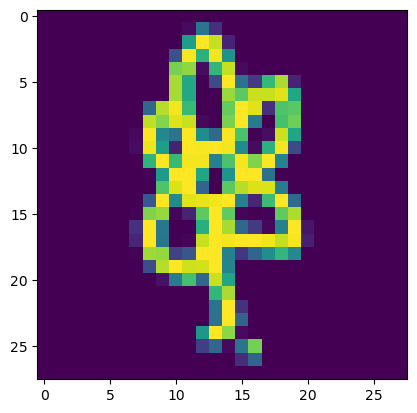

In [10]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))

In [11]:
print(class_names[int(y_train[idx].item())])

flower


# Preprocess the Data

In [12]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model

**MODEL 1**

In [13]:
# Define model
from keras.layers import Convolution2D, MaxPooling2D, LSTM, Dense, Flatten, Dropout, BatchNormalization, Bidirectional

model = keras.Sequential()
model.add(Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(32, (3, 3),
                        padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, (3, 3),
                        padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3, 3),
                        padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))

# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

/home/radak/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-21 19:38:13.513021: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,524 (498.14 KB)

 Trainable params: 127,044 (496.27 KB)

 Non-trainable params: 480 (1.88 KB)

None


**Visualize the Training model**

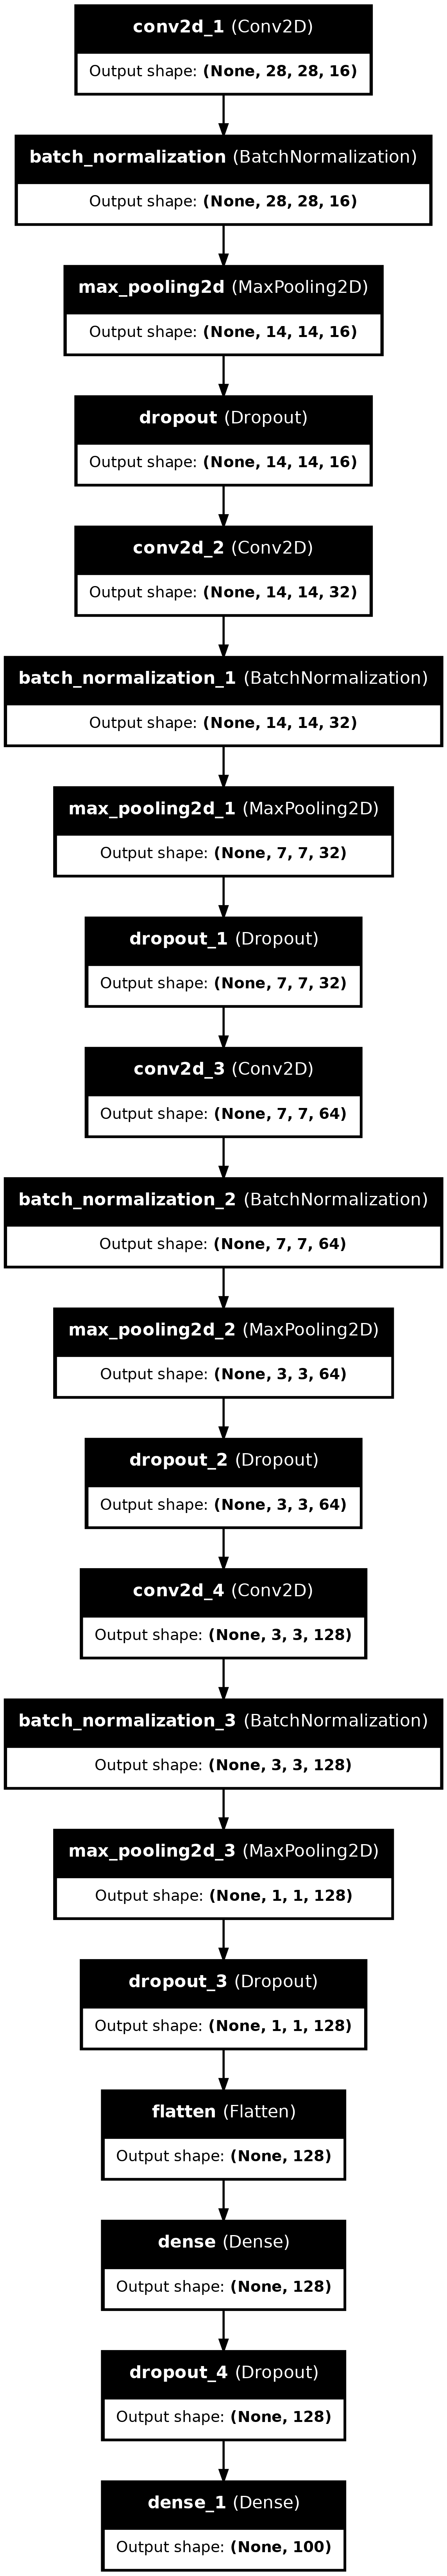

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='conv_model_plot.png', show_shapes=True, show_layer_names=True)

# Training

In [15]:
model.fit(x = x_train, y = y_train, validation_split=0.05, batch_size = 64, verbose=2, epochs=100)

Epoch 1/100
4750/4750 - 114s - 24ms/step - loss: 2.5296 - top_k_categorical_accuracy: 0.6664 - val_loss: 1.4114 - val_top_k_categorical_accuracy: 0.8743
Epoch 2/100
4750/4750 - 114s - 24ms/step - loss: 1.8387 - top_k_categorical_accuracy: 0.8150 - val_loss: 1.2221 - val_top_k_categorical_accuracy: 0.8968
Epoch 3/100
4750/4750 - 98s - 21ms/step - loss: 1.6883 - top_k_categorical_accuracy: 0.8372 - val_loss: 1.1311 - val_top_k_categorical_accuracy: 0.9046
Epoch 4/100
4750/4750 - 108s - 23ms/step - loss: 1.6153 - top_k_categorical_accuracy: 0.8464 - val_loss: 1.1070 - val_top_k_categorical_accuracy: 0.9081
Epoch 5/100
4750/4750 - 108s - 23ms/step - loss: 1.5724 - top_k_categorical_accuracy: 0.8530 - val_loss: 1.0520 - val_top_k_categorical_accuracy: 0.9136
Epoch 6/100
4750/4750 - 105s - 22ms/step - loss: 1.5303 - top_k_categorical_accuracy: 0.8598 - val_loss: 1.0154 - val_top_k_categorical_accuracy: 0.9176
Epoch 7/100
4750/4750 - 104s - 22ms/step - loss: 1.5025 - top_k_categorical_accurac

Epoch 55/100
4750/4750 - 102s - 21ms/step - loss: 1.3088 - top_k_categorical_accuracy: 0.8836 - val_loss: 0.8815 - val_top_k_categorical_accuracy: 0.9267
Epoch 56/100
4750/4750 - 102s - 21ms/step - loss: 1.3052 - top_k_categorical_accuracy: 0.8849 - val_loss: 0.8785 - val_top_k_categorical_accuracy: 0.9281
Epoch 57/100
4750/4750 - 102s - 22ms/step - loss: 1.3042 - top_k_categorical_accuracy: 0.8844 - val_loss: 0.8776 - val_top_k_categorical_accuracy: 0.9274
Epoch 58/100
4750/4750 - 102s - 21ms/step - loss: 1.3055 - top_k_categorical_accuracy: 0.8841 - val_loss: 0.8840 - val_top_k_categorical_accuracy: 0.9277
Epoch 59/100
4750/4750 - 102s - 21ms/step - loss: 1.3037 - top_k_categorical_accuracy: 0.8845 - val_loss: 0.8800 - val_top_k_categorical_accuracy: 0.9281
Epoch 60/100
4750/4750 - 103s - 22ms/step - loss: 1.3002 - top_k_categorical_accuracy: 0.8847 - val_loss: 0.8776 - val_top_k_categorical_accuracy: 0.9284
Epoch 61/100
4750/4750 - 100s - 21ms/step - loss: 1.3024 - top_k_categorical

# Training Accuracy

In [16]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Train accuarcy: {:0.2f}%'.format(score[1] * 100))

Train accuarcy: 93.67%


# Test Accuracy

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 93.17%


# Inference

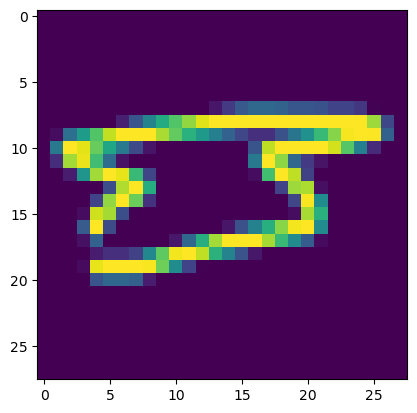

In [20]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())

In [21]:
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
['anvil', 'diving_board', 'bread', 'lightning', 't-shirt']


# Store the classes

In [ ]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [ ]:
!pip install tensorflowjs

# Save and Convert

In [23]:
model.save('sketchyguys.keras')

In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Zip and Download

In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model

In [ ]:
from google.colab import files
files.download('model.zip')